In [49]:
import pandas as pd
import numpy as np
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder

// Установка библиотеки seaborn для построения парных графиков

!pip install -q seaborn

Полезные ссылки:

1) Регрессия, задача по расходу топлива: https://www.tensorflow.org/tutorials/keras/regression?hl=ru;  

In [2]:
# --- Подготовка данных. Получение эксель-файла только с необходимыми столбцами ---

# Чтение данных с наименованиями полей
data_column_names = pd.read_excel('../input_data/data_from_site3.xlsx', sheet_name = 'names')

# Удаление событий сс пустыми значениями в поле checked_parameter
data_column_names['checked_parameter'].replace('', np.nan, inplace = True)
data_column_names.dropna(subset = ['checked_parameter'], inplace = True)

# Получение списка исследуемых параметров
list_data_necessary = []
for n_data in data_column_names['N']:
    list_data_necessary.append(n_data)
    
# Получение всех данных теста
data_all = pd.read_excel('../input_data/data_from_site2.xlsx', sheet_name = 'data')

# Получение данных по иследуемым параметрам
data_necessary = data_all[list_data_necessary]
data_necessary.head()

# Переименование заголовков столбцов
old_names = list_data_necessary
new_names = data_necessary.loc[0]
data_necessary.rename(columns = dict(zip(old_names, new_names)), inplace = True) 
data_necessary.drop([0], inplace = True)

# Создание столбца "Тип_занятости" взамен разрозненных данных
data_necessary['Тип_занятости'] = 0
data_necessary.loc[data_necessary['Владелец_предприятия'] == 1, 'Владелец_предприятия'] = 2
data_necessary.loc[data_necessary['ИП'] == 1, 'ИП'] = 3
data_necessary.loc[data_necessary['Фермер'] == 1, 'Фермер'] = 4
data_necessary.loc[data_necessary['Свободный_работник'] == 1, 'Свободный_работник'] = 5
data_necessary.loc[data_necessary['Мессенджеры_нет'] == '     .  ', 'Мессенджеры_нет'] = 99

for index, row in data_necessary.iterrows():
    if data_necessary['Наемный_работник'][index] == 1:
        data_necessary['Тип_занятости'][index] = data_necessary['Наемный_работник'][index]
    if data_necessary['Владелец_предприятия'][index] == 2:
        data_necessary['Тип_занятости'][index] = data_necessary['Владелец_предприятия'][index] 
    if data_necessary['ИП'][index] == 3:
        data_necessary['Тип_занятости'][index] = data_necessary['ИП'][index] 
    if data_necessary['Фермер'][index] == 4:
        data_necessary['Тип_занятости'][index] = data_necessary['Фермер'][index] 
    if data_necessary['Свободный_работник'][index] == 5:
        data_necessary['Тип_занятости'][index] = data_necessary['Свободный_работник'][index]  
    if data_necessary['Сумма_пенсии'][index] != '     .  ':
        data_necessary['Тип_занятости'][index] = 6
        data_necessary['Профессия_должность'][index] = 'пенсионер'
        data_necessary['Деятельность_компании'][index] = 'Пенсионный_Фонд_РФ'
        

drop_list = ['Наемный_работник', 'Владелец_предприятия', 'ИП', 'Фермер', 'Свободный_работник']        
data_necessary.drop(drop_list, axis = 'columns', inplace = True)  

# Сохранение отчасти подготовленных данных в файл
data_necessary.to_excel('../output_data/data_to_experiments.xlsx', sheet_name = 'data')

# # Проверка полученных данных по первым 5 значениям
# print(data_necessary.head())

# Удаление переменной для исключения конфликтов при повторном использовании
del data_necessary

# ---------------------------------------------------------------------------------

C:\Users\Tasha\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\Tasha\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\Tasha\anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\User

Поскольку в полученных данных присутствуют суммы зарплаты и пенсии, то стоит выбор в методе обработки данных значений

1 вариант - нормализация столбцов, дополнение пустых столбцов по з/п данными пенсиями. По заполненным данным: среднее арифметическое? Или сумма без нормализации

2 вариант - сумму з/п и пенсии "=" уровень потребностей и коммуникаций, но не является логичным показателем субъективных ощущений.
(Т.к. низкий уровень пенсии и вынужденная работа может показать сумму, превышающую величину более высокой пенсии, но свидетельствовать о более низкой оценке себя...)
подходит для оценки показателей "Тип_занятости", "Количество_детей", ...


In [123]:
# --- Подготовка данных. Предварительная обработка необходимых столбцов  ---

# Чтение данных
data_necessary = pd.read_excel('../output_data/data_to_experiments.xlsx', sheet_name = 'data')

# Удаление первого столбца с номерами строк, "доставщихся по наследству" от первого файла
data_necessary.drop(data_necessary.columns[[0]], axis=1, inplace=True) 

# Объединение столбцов с пенсией и зарплатой
data_necessary.loc[data_necessary['Средняя_зарплата_месяц'] == '     .  ', 'Средняя_зарплата_месяц'] = 0
data_necessary.loc[data_necessary['Сумма_пенсии'] == '     .  ', 'Сумма_пенсии'] = 0
data_necessary.loc[data_necessary['Средняя_зарплата_месяц'] == 0, 'Средняя_зарплата_месяц'] = data_necessary['Средняя_зарплата_месяц'] + data_necessary['Сумма_пенсии']
data_necessary.rename(columns = dict(zip(['Средняя_зарплата_месяц'], ['Размер_зарплаты_пенсии'])), inplace = True) 
del data_necessary['Сумма_пенсии'] 

# Удаление строк с неуказанной зарплатой
data_necessary['Размер_зарплаты_пенсии'].replace(0, np.nan, inplace=True)
data_necessary.dropna(subset=['Размер_зарплаты_пенсии'], inplace=True)

# Проверка пустых значений
data_necessary.loc[data_necessary['Мессенджеры_нет'] == '       .', 'Мессенджеры_нет'] = pd.NA
for title in list(data_necessary.columns.values):
    data_necessary.loc[data_necessary[title] == 99, title] = pd.NA  
    print(f'Поле {title}. Нулей: {data_necessary[title].isnull().sum()}.')
    
# Присвоение 1859 пустым значениям в поле 'Мессенджеры_нет' значения 2 - не ответил
data_necessary['Мессенджеры_нет'] = data_necessary['Мессенджеры_нет'].fillna(2)  

# Присвоение пустым полям 'Степень_состоятельности', 'Степень_власти', 'Степень_уважения_другими' значения 0 - не ответил
for title in ['Степень_состоятельности', 'Степень_власти', 'Степень_уважения_другими']:
    data_necessary[title] = data_necessary[title].fillna(0)  
    
# Кодирование полей Профессия_должность и Деятельность_компании 
encode = LabelEncoder()
data_necessary['Профессия_должность'] = pd.Series(encode.fit_transform(data_necessary['Профессия_должность']))
data_necessary['Деятельность_компании'] = pd.Series(encode.fit_transform(data_necessary['Деятельность_компании']))

# Сохранение подготовленных данных в файл
data_necessary.to_excel('../output_data/ready_data.xlsx', sheet_name = 'data')

# Удаление переменной для исключения конфликтов при повторном использовании
del data_necessary

# Отображение данных по датафрейму
# len(data_necessary)
# data_necessary

Поле Степень_состоятельности. Нулей: 110.
Поле Степень_власти. Нулей: 259.
Поле Степень_уважения_другими. Нулей: 309.
Поле Состав_семьи. Нулей: 0.
Поле Наличие_детей. Нулей: 0.
Поле Уровень_образования. Нулей: 0.
Поле Профессия_должность. Нулей: 0.
Поле Деятельность_компании. Нулей: 0.
Поле Размер_зарплаты_пенсии. Нулей: 0.
Поле Верующий. Нулей: 0.
Поле Пользование_интернетом. Нулей: 0.
Поле Мессенджеры_нет. Нулей: 1859.
Поле Проживание_область. Нулей: 0.
Поле Проживание_населенный_пункт. Нулей: 0.
Поле Тип_занятости. Нулей: 0.


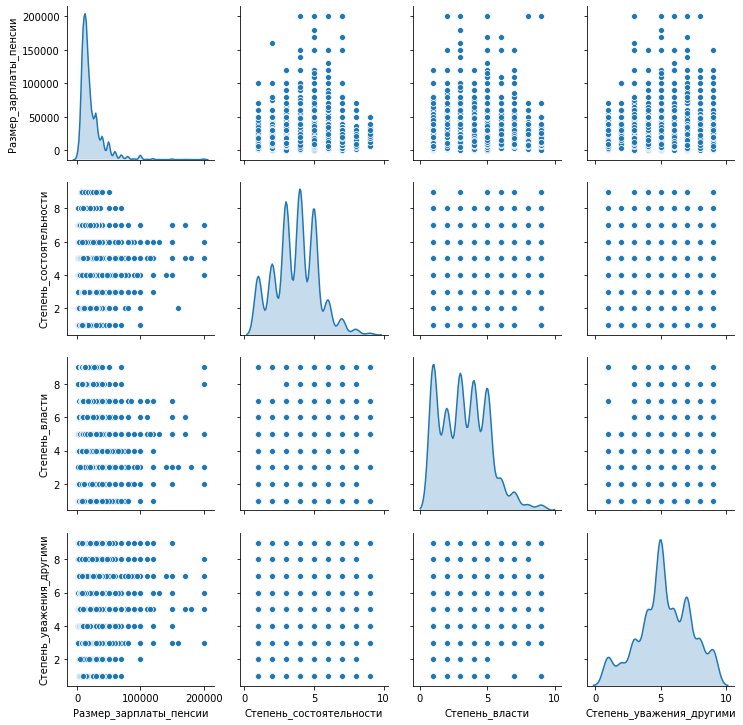

In [133]:
# --- Распределение данных ---

# Чтение данных
data_necessary = pd.read_excel('../output_data/ready_data.xlsx', sheet_name = 'data')

# Удаление первого столбца с номерами строк, "доставщихся по наследству" от первого файла
data_necessary.drop(data_necessary.columns[[0]], axis=1, inplace=True) 

# Деление данных на обучающую и тестовую выборки
x_train = data_necessary.sample(frac=0.8,random_state=0)
x_test = data_necessary.drop(x_train.index)

# # Проверка размеров выборок
# print(f'Размер обучающей выборки: {len(train_dataset)}; тестовой - {len(test_dataset)}.')

# Сохранение данных по выборкам в файл
x_train.to_excel('../output_data/train_dataset.xlsx', sheet_name = 'data')
x_test.to_excel('../output_data/test_dataset.xlsx', sheet_name = 'data')

# Отображение графиков по некоторым полям
sns.pairplot(train_dataset[['Размер_зарплаты_пенсии', 'Степень_состоятельности', 'Степень_власти', 'Степень_уважения_другими']], diag_kind="kde");

In [134]:
# Просмотр общих статистик
train_stats = x_train.describe()
train_stats.pop('Размер_зарплаты_пенсии')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Степень_состоятельности,6281.0,3.659768,1.608196,0.0,3.0,4.0,5.0,9.0
Степень_власти,6281.0,3.180067,1.833315,0.0,2.0,3.0,5.0,9.0
Степень_уважения_другими,6281.0,5.121000,2.228794,0.0,4.0,5.0,7.0,9.0
Состав_семьи,6281.0,2.987582,1.548732,1.0,2.0,3.0,4.0,15.0
Наличие_детей,6281.0,1.183569,0.387164,1.0,1.0,1.0,1.0,2.0
Уровень_образования,6281.0,3.053813,1.056811,1.0,3.0,3.0,4.0,9.0
Профессия_должность,5135.0,1459.356573,565.630532,0.0,1166.0,1711.0,1711.0,2435.0
Деятельность_компании,5135.0,956.057059,873.885784,1.0,318.0,318.0,1595.5,3012.0
Верующий,6281.0,1.537812,1.489735,1.0,1.0,1.0,2.0,9.0
Пользование_интернетом,6281.0,1.990447,0.757071,1.0,2.0,2.0,2.0,9.0


In [135]:
# Деление данных на целевые значения и признаки
y_train = x_train.pop('Размер_зарплаты_пенсии')
y_test = x_test.pop('Размер_зарплаты_пенсии')

# Нормализация данных
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(x_train)
normed_test_data = norm(x_test)

In [136]:
# Построение модели

def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
        ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [137]:
model = build_model()

In [138]:
# Отображение описания модели
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1024      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,249
Trainable params: 5,249
Non-trainable params: 0
_________________________________________________________________


In [142]:
# from __future__ import absolute_import, division, print_function, unicode_literals

# import pathlib

# import matplotlib.pyplot as plt
# import pandas as pd
# import seaborn as sns

# import tensorflow as tf

# from tensorflow import keras
# from tensorflow.keras import layers

In [143]:
# Проверка модели
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

ValueError: Error when checking input: expected dense_input to have shape (15,) but got array with shape (14,)